# Reconstruction with Keras


In [96]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

from matplotlib.patches import Ellipse
import numpy as np
import math
import matplotlib.pyplot as plt
import random as rd
import sys

# Add the Utilties directory to the system path so the file sipm_param can be imported.
sys.path.append("../Utilities")
from sipm_param import *

The parameterization is done in two time bins and can be accessed through the function sipm_par(tbin, r) defined in Utilities/sipm_param.py.  Here tbin is the time bin and r is the radial distance from the EL point at which the SiPM of interest is located.

In [64]:
# Geometry definition.
nsipm = 8
sipm_pitch = 10.       # distance between SiPMs
sipm_edge_width = 5.   # distance between SiPM and edge of board

# Number of EL points to generate per event.
N_ELpts = 2

# Variables for computing an EL point location.
xlen = 2*sipm_edge_width + 7*sipm_pitch       # (mm) side length of rectangle
ylen = 2*sipm_edge_width + 7*sipm_pitch       # (mm) side length of rectangle
wbin = 2.0                                    # (mm) bin width

# Compute the positions of the SiPMs.
pos_x = np.ones(nsipm**2)*sipm_edge_width + (np.ones(nsipm*nsipm)*range(nsipm**2) % nsipm)*sipm_pitch
pos_y = np.ones(nsipm**2)*sipm_edge_width + np.floor(np.ones(nsipm*nsipm)*range(nsipm**2) / nsipm)*sipm_pitch

In [78]:
# Number of events to generate.
Nevts_train = 10000
Nevts_test = 1000

# Set up the training sets.
x_train = np.zeros([Nevts_train,nsipm*nsipm]); x_test = np.zeros([Nevts_test,nsipm*nsipm])
y_train = np.zeros([Nevts_train,2*N_ELpts]); y_test = np.zeros([Nevts_test,2*N_ELpts])

# Generate the events.
Nevts = Nevts_train + Nevts_test
for nn in range(Nevts):

    if(nn % int(Nevts/10) == 0):
        print "-- Event {0} of {1} ...".format(nn,Nevts)

    # For each event, generate a number of random EL points and compute the probabilities of detection for each SiPM.
    sipm_map = np.zeros(nsipm*nsipm)
    for npt in range(N_ELpts):
        
        # Generate the point.
        xpt = rd.random()*xlen
        ypt = rd.random()*ylen

        # Compute the distances and probabilities.  Add the probabilities to the sipm map.
        rr = np.array([math.sqrt((xi - xpt)**2 + (yi - ypt)**2) for xi,yi in zip(pos_x,pos_y)])
        probs = 0.5*(sipm_par(0, rr) + sipm_par(1, rr))
        sipm_map += probs
        
        # Fill the y matrix with the generated points.
        if(nn >= Nevts_train):
            y_test[nn-Nevts_train][2*npt] = xpt/xlen
            y_test[nn-Nevts_train][2*npt+1] = ypt/ylen
        else:
            y_train[nn][2*npt] = xpt/xlen
            y_train[nn][2*npt+1] = ypt/ylen

    # Normalize the probability map, and set sigma = 1.
    sipm_map -= np.mean(sipm_map)
    sipm_map /= np.std(sipm_map)
    
    # Fill the x matrix for the generated points.
    if(nn >= Nevts_train):
        x_test[nn-Nevts_train] = sipm_map
    else:
        x_train[nn] = sipm_map

-- Event 0 of 11000 ...
-- Event 1100 of 11000 ...
-- Event 2200 of 11000 ...
-- Event 3300 of 11000 ...
-- Event 4400 of 11000 ...
-- Event 5500 of 11000 ...
-- Event 6600 of 11000 ...
-- Event 7700 of 11000 ...
-- Event 8800 of 11000 ...
-- Event 9900 of 11000 ...


In [108]:
# Construct a DNN.
model = Sequential()
model.add(Dense(output_dim=1024, input_dim=nsipm*nsipm))
model.add(Activation("relu"))
model.add(Dense(output_dim=1024))
model.add(Activation("relu"))
model.add(Dense(output_dim=1024))
model.add(Activation("relu"))
model.add(Dense(output_dim=2*N_ELpts))
model.add(Activation("sigmoid"))
model.compile(loss='mse', optimizer=SGD(lr=1.0, momentum=0.9, nesterov=True))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_31 (Dense)                 (None, 1024)          66560       dense_input_13[0][0]             
____________________________________________________________________________________________________
activation_31 (Activation)       (None, 1024)          0           dense_31[0][0]                   
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 1024)          1049600     activation_31[0][0]              
____________________________________________________________________________________________________
activation_32 (Activation)       (None, 1024)          0           dense_32[0][0]                   
___________________________________________________________________________________________

In [109]:
model.fit(x_train, y_train, nb_epoch=100, batch_size=100);

Epoch 1/100
10000/10000 [==============================] - 3s - loss: 0.0459     
Epoch 2/100
10000/10000 [==============================] - 3s - loss: 0.0423     
Epoch 3/100
10000/10000 [==============================] - 3s - loss: 0.0413     
Epoch 4/100
10000/10000 [==============================] - 3s - loss: 0.0403     
Epoch 5/100
10000/10000 [==============================] - 3s - loss: 0.0394     
Epoch 6/100
10000/10000 [==============================] - 3s - loss: 0.0384     
Epoch 7/100
10000/10000 [==============================] - 4s - loss: 0.0376     
Epoch 8/100
10000/10000 [==============================] - 3s - loss: 0.0365     
Epoch 9/100
10000/10000 [==============================] - 4s - loss: 0.0357     
Epoch 10/100
10000/10000 [==============================] - 4s - loss: 0.0347     
Epoch 11/100
10000/10000 [==============================] - 4s - loss: 0.0337     
Epoch 12/100
10000/10000 [==============================] - 4s - loss: 0.0327     
Epoch 13/100


In [117]:
# Evaluate the model and produce a list of predictions for the test data.
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=100);
y_pred = model.predict(x_train, batch_size=32, verbose=0)
print("\nMean loss is {0}".format(loss_and_metrics))

1000/1000 [==============================] - 0s     

Mean loss is 0.0697301927954


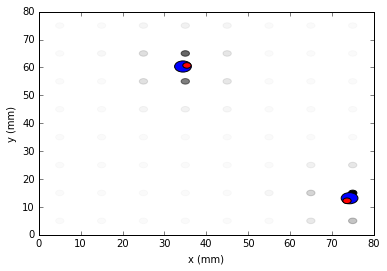

In [121]:
# Plot one event.
plt_train = True
pevt = 2
fig = plt.figure();
ax1 = fig.add_subplot(111);
ax1.axis([0, xlen, 0, ylen]);

if(plt_train):
    xarr = x_train[pevt]
    yarr = y_train[pevt]
else:
    xarr = x_test[pevt]
    yarr = y_test[pevt]

# Create circles and plot them according to the probabilities.
probs = (xarr - min(xarr))
probs /= max(probs)
for x,y,p in zip(pos_x, pos_y, probs):

    #print "Placing sipm at ({0},{1}) with prob {2}".format(x,y,p);
    
    # Set up the location; note we must invert y due to a pi rotation
    #  about the x-axis.
    r = Ellipse(xy=(x,y), width=2., height=2.);
    r.set_facecolor('0');
    r.set_alpha(0.02 + 0.98*p);
    ax1.add_artist(r);

# Place large blue circles for actual EL points.
for npt in range(len(yarr)/2):
    xpt = yarr[2*npt]*xlen
    ypt = yarr[2*npt+1]*ylen
    mrk = Ellipse(xy=(xpt,ypt), width=4., height=4.);
    mrk.set_facecolor('b');
    ax1.add_artist(mrk);
    
# Place small red circles for predicted EL points.
for npt in range(len(y_pred[pevt])/2):
    xpt = y_pred[pevt][2*npt]*xlen
    ypt = y_pred[pevt][2*npt+1]*ylen
    mrk = Ellipse(xy=(xpt,ypt), width=2., height=2.);
    mrk.set_facecolor('r');
    ax1.add_artist(mrk);

# Show the plot.
plt.xlabel("x (mm)");
plt.ylabel("y (mm)");